# Capstone - Dice Classifier Model

Note the data was sourced, cleaned, and prepared in [eda.ipynb](eda.ipynb) prior to this model creation

**WARNING: batch size was tuned based on my GPU memory to avoid fragmentation and other memory errors.**  

**I would not recommend attempting to run this project without a GPU enabled tensorflow build as it will take hours or days to run. For example, a single epoch that takes ~30 seconds took ~30 minutes when I trained on only CPU**  

## Dependencies

### Install

In [5]:
#!pip uninstall tensorflow -y

In [6]:
#installing version 1.25 as subpackages in tensorflow require numpy<1.26, >=1.21
!pip install numpy==1.25

In [7]:
!pip install tensorflow[and-cuda]

  Obtaining dependency information for tensorflow[and-cuda] from https://files.pythonhosted.org/packages/4e/4d/a92351de8e261d0e8afaa56cdff1429551d1111e6f177cda13f75dd96b98/tensorflow-2.15.0.post1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tensorflow-2.15.0.post1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached tensorflow-2.15.0.post1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)


### Import

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img #load images with keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

2023-12-07 17:35:16.418118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 17:35:16.418172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 17:35:16.418784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 17:35:16.422557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 17:35:17.044089: W tensorflow/compiler/tf2

## Neural Network

### Model Selection

Keras offers pretrained models at [keras.io](https://keras.io/api/applications/)  
I am using the Xception model due to the very high accuracy with somewhat low depth required

### Transfer Learning

The Xception model takes images of shape 299, 299, 3 while our images are shape 480, 480, 3
We are going to utilize transfer learning to allow this model to accept our images

In [9]:
#train
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input) #same preprocess_input as earlier

train_ds = train_gen.flow_from_directory(
    'split_data/train',
    target_size=(480, 480),
    batch_size=100
)

Found 6300 images belonging to 6 classes.


In [10]:
#check
train_ds.class_indices #show class index, infered from folder structure

{'d10': 0, 'd12': 1, 'd20': 2, 'd4': 3, 'd6': 4, 'd8': 5}

In [11]:
#validation
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input) #same preprocess_input as earlier

val_ds = val_gen.flow_from_directory(
    'split_data/val',
    target_size=(480, 480),
    batch_size=100,
    shuffle=False #we don't have to shuffle for validation
)

Found 2100 images belonging to 6 classes.


In [12]:
#check
val_ds.class_indices #show class index, infered from folder structure

{'d10': 0, 'd12': 1, 'd20': 2, 'd4': 3, 'd6': 4, 'd8': 5}

### Generating a Test Image

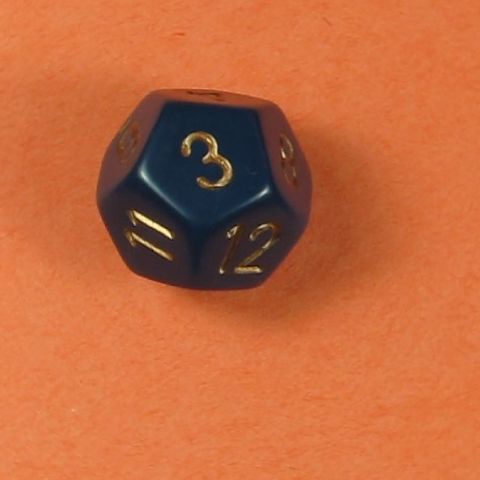

In [13]:
#load a sample image from dataset
path = 'split_data/test/d12'
name = 'd12_color019.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

#load image into variable
img = load_img(fullname)
img

In [14]:
#convert image to array 
x = np.array(img)
x.shape

(480, 480, 3)

In [15]:
#add extra dimension as model expects a batch of images
X = np.array([x])
X.shape

(1, 480, 480, 3)

In [16]:
#preprocess image
X = preprocess_input(X)

### Base Model

In [17]:
#first we get the basemodel (convolutional layers) ie the "bottom" in keras terms
base_model = Xception( #get pretrained model
    weights='imagenet', #same as before, this is standard for this pretrained model
    include_top=False, #this leaves out the dense layers "top" where convolutional layers are "bottom"
    input_shape=(480, 480, 3)
)

base_model.trainable = False #this is because when we train the model we don't want to change the convolutional layers


2023-12-07 17:35:18.549792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 17:35:18.570728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 17:35:18.570780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 17:35:18.572520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 17:35:18.572564: I external/local_xla/xla/stream_executor

In [18]:
inputs = keras.Input(shape=(480, 480, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base) #turning 3 dimensions into 1 dimension

outputs = keras.layers.Dense(6)(vectors) #6 due to number of classes we have

#wrap it in a keras model
model = keras.Model(inputs, outputs)

In [19]:
#test model with the test image
preds = model.predict(X)

2023-12-07 17:35:20.656799: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-07 17:35:20.713727: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-07 17:35:21.042424: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 1s 999ms/step


In [20]:
preds.shape

(1, 6)

### Train Model

In [21]:
"""
there are many optimizers https://keras.io/api/optimizers/
they usually use gradient descent
Adam is currently the recommended starting point for all models
"""
learning_rate = 0.1
optimizer = keras.optimizers.Adam(learning_rate=learning_rate) 

"""
for multi class categorization: CategoricalCrossentropy
for log regression: BinaryCrossentropy
for linear regression: MeanSquaredErrorCrossentropy
"""
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
"""
in the dense layers the model takes inputs, generates outputs and then there is a softmax aka activation applied
from_logits = True means we dont apply activation and get row score
from_logits = False means we apply activation and get probabilities
"""

'\nin the dense layers the model takes inputs, generates outputs and then there is a softmax aka activation applied\nfrom_logits = True means we dont apply activation and get row score\nfrom_logits = False means we apply activation and get probabilities\n'

In [22]:
#compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) #this will show accuracy at each step

Note that since this is a preliminary run without tuning any hyperparameters I am using a large batch size and a small amount of epochs:  
- batch_size = 150
- epochs = 3  

A more ideal setup:
- batch_size = 150
- epochs = 3

In [23]:
#fit model
"""
the model goes over the dataset batch by batch generally
if we specify an epoch then it will go over the dataset batch by batch that many times
"""
history = model.fit(train_ds, epochs=5, validation_data=val_ds) 

Epoch 1/5
 1/63 [..............................] - ETA: 6:20 - loss: 1.7498 - accuracy: 0.1600

2023-12-07 17:35:27.839232: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa5af845d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-07 17:35:27.839269: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-12-07 17:35:27.843524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701988527.905911 2071766 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - 48s 682ms/step - loss: 0.5605 - accuracy: 0.8914 - val_loss: 0.0063 - val_accuracy: 0.9976
Epoch 2/5
63/63 [==============================] - 43s 678ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 0.0044 - val_accuracy: 0.9981
Epoch 3/5
63/63 [==============================] - 43s 679ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0028 - val_accuracy: 0.9990
Epoch 4/5
63/63 [==============================] - 43s 678ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0065 - val_accuracy: 0.9981
Epoch 5/5
63/63 [==============================] - 43s 676ms/step - loss: 6.7434e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9995


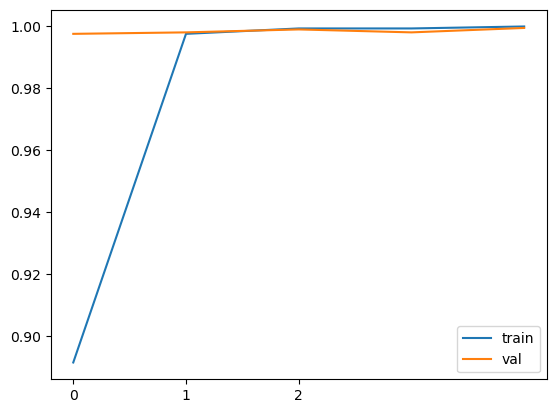

In [24]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.xticks(np.arange(3))
plt.legend()

It appears the model is very accurate but overfitting quite aggressively.  
Decreasing the learning rate will likely help us.

## Tune Model

### Compile full model thus far

In [25]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(480, 480, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(480, 480, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

### Learning Rate

In [28]:
scores = {}

for lr in [0.001, 0.05, 0.01]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.001
Epoch 1/10
63/63 [==============================] - 47s 704ms/step - loss: 1.0727 - accuracy: 0.7778 - val_loss: 0.6181 - val_accuracy: 0.9348
Epoch 2/10
63/63 [==============================] - 43s 682ms/step - loss: 0.4672 - accuracy: 0.9517 - val_loss: 0.3482 - val_accuracy: 0.9695
Epoch 3/10
63/63 [==============================] - 43s 687ms/step - loss: 0.2940 - accuracy: 0.9737 - val_loss: 0.2378 - val_accuracy: 0.9814
Epoch 4/10
63/63 [==============================] - 43s 686ms/step - loss: 0.2112 - accuracy: 0.9840 - val_loss: 0.1768 - val_accuracy: 0.9886
Epoch 5/10
63/63 [==============================] - 44s 687ms/step - loss: 0.1618 - accuracy: 0.9883 - val_loss: 0.1390 - val_accuracy: 0.9924
Epoch 6/10
63/63 [==============================] - 43s 687ms/step - loss: 0.1294 - accuracy: 0.9919 - val_loss: 0.1137 - val_accuracy: 0.9957
Epoch 7/10
63/63 [==============================] - 44s 692ms/step - loss: 0.1077 - accuracy: 0.9935 - val_loss: 0.0958 - val_accuracy: 

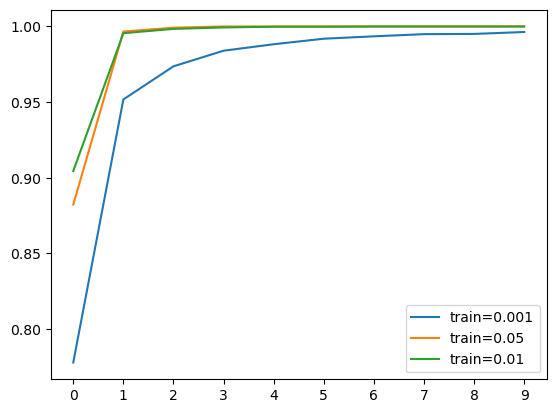

In [32]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    #plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

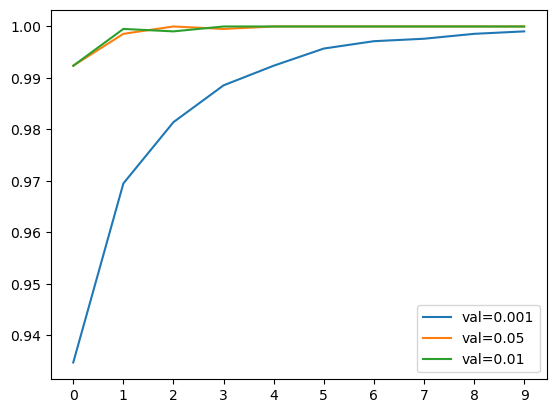

In [33]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

I am a bit concerned that the higher learning rates may be over fitting because of how quickly the training datasets are hitting 100% accuracy. Because of this I am going to use the 0.001 learning rate and remain at 10 epochs.

A popular approach that can be used next is called callback.  
What callbacks do is retains the history of each iteration and will revert back when accuracy drops.  
Because of how smooth our accuracy curve is I do not feel this is necessary. 

Although our accuracy is high adding an extra layer could improve it further.

### Adding more layers

In [36]:
def make_model(learning_rate=0.001, size_inner=100): #adding size_inner for new dense layer size
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(480, 480, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(480, 480, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) #adding inner layer using ReLu activation function

    outputs = keras.layers.Dense(6)(inner) #change input from vectors to inner
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

We are using the ReLu inner activation function because it is standard in intermediate layers.  
We have not introduced a new hyper parameter to tune, the layer size.

In [43]:
#tune inner layer size
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
63/63 [==============================] - 48s 722ms/step - loss: 1.2805 - accuracy: 0.6421 - val_loss: 0.8098 - val_accuracy: 0.9162
Epoch 2/10
63/63 [==============================] - 44s 689ms/step - loss: 0.5426 - accuracy: 0.9422 - val_loss: 0.3377 - val_accuracy: 0.9657
Epoch 3/10
63/63 [==============================] - 44s 687ms/step - loss: 0.2543 - accuracy: 0.9773 - val_loss: 0.1854 - val_accuracy: 0.9833
Epoch 4/10
63/63 [==============================] - 44s 691ms/step - loss: 0.1518 - accuracy: 0.9873 - val_loss: 0.1166 - val_accuracy: 0.9919
Epoch 5/10
63/63 [==============================] - 44s 692ms/step - loss: 0.1031 - accuracy: 0.9914 - val_loss: 0.0842 - val_accuracy: 0.9957
Epoch 6/10
63/63 [==============================] - 43s 684ms/step - loss: 0.0747 - accuracy: 0.9944 - val_loss: 0.0620 - val_accuracy: 0.9981
Epoch 7/10
63/63 [==============================] - 44s 691ms/step - loss: 0.0568 - accuracy: 0.9962 - val_loss: 0.0485 - val_accuracy: 0.9

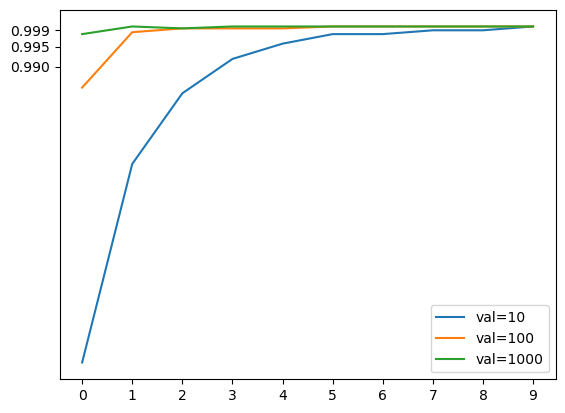

In [48]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.990, 0.995, 0.999])
plt.legend()

Remaining with the 10 epoch setup I like the convergence of all of these. Depth 10 will get the job done but 100 is more accurate early so I will continue with 100.

### Dropout

Now let us introduce dropout.  

Dropout can be described as placing a black box that blocks out portions of the image to make sure that certain specific patterns are not learned by the machine.  

A dropout refers to a % which corresponds to how much % of the image is blocked out ie a dropout of 0.5 means 50% of the layer is frozen.

In [50]:
def make_model(learning_rate=0.001, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(480, 480, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(480, 480, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) 
    drop = keras.layers.Dropout(droprate)(inner) #applying dropout to the inner layer
    
    outputs = keras.layers.Dense(6)(drop) #use the drop instead of the inner as input
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

Training dropout

Note that I am increasing the epochs here to account for dropout having more time to work.

In [51]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=20, validation_data=val_ds) #increasing epochs to allow dropout more time to work
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/20
63/63 [==============================] - 47s 707ms/step - loss: 0.4621 - accuracy: 0.9063 - val_loss: 0.1089 - val_accuracy: 0.9857
Epoch 2/20
63/63 [==============================] - 44s 692ms/step - loss: 0.0670 - accuracy: 0.9927 - val_loss: 0.0403 - val_accuracy: 0.9981
Epoch 3/20
63/63 [==============================] - 45s 705ms/step - loss: 0.0318 - accuracy: 0.9973 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 4/20
63/63 [==============================] - 44s 698ms/step - loss: 0.0187 - accuracy: 0.9995 - val_loss: 0.0145 - val_accuracy: 0.9995
Epoch 5/20
63/63 [==============================] - 44s 701ms/step - loss: 0.0122 - accuracy: 0.9997 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 6/20
63/63 [==============================] - 44s 703ms/step - loss: 0.0086 - accuracy: 0.9997 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 7/20
63/63 [==============================] - 45s 705ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 1.

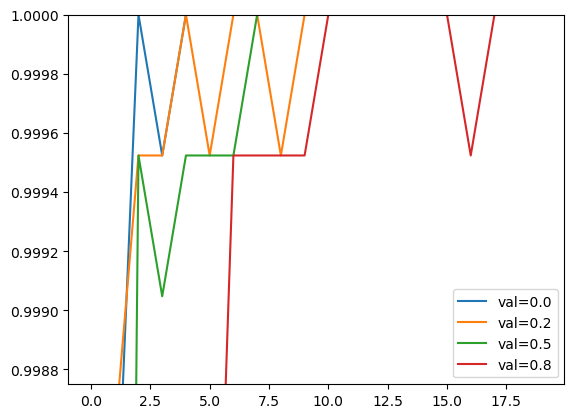

In [55]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.99875, 1.00)
plt.legend()

It seems that this is overkill. and regardless of the amount of dropout the accuracy will still reach 100%.  
I do not feel that this metric or the increased amount of epochs are necessary for this model.

### Data augmentation

Previously we used epochs where the model would see the same images multiple times. To solve for overfitting in this scenario we implemented dropout.  

There is another way to address this problem where we generate more images via transformations.    

Image transformations:
1. Flip - Horizontal and Vertical
2. Rotation (note you may lose some of image)
3. Shifting - Heigh and Width (note you may lose some of image)
4. Shear ie pulling from corners
5. Zoom - X and Y axis or on both
6. Brightness & Contrast
7. Black Patch

In our case we can utilize some of these transformations to imitate what may be seen in a real image.  
1. Flip - Horizontal and Vertical
2. Rotation (note you may lose some of image)
3. Shifting - Heigh and Width (note you may lose some of image)
4. ~~Shear ie pulling from corners~~
5. Zoom - X and Y axis or on both
6. ~~Brightness & Contrast~~
7. ~~Black Patch~~

In [57]:
"""
There are many optional settings in ImageDataGenerator
Note prior code we are replacing:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
"""
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rotation_range=30, #rotate
    #width_shift_range=10.0, #shift
    #height_shift_range=10.0, #shift
    #shear_range=10.0, #shear
    #zoom_range=0.1, #zoom
    #vertical_flip=True, #flip
)

train_ds = train_gen.flow_from_directory(
    'split_data/train',
    target_size=(480, 480),
    batch_size=100
)

#note we do not want to apply the preprocessing function to the validation set
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    'split_data/val',
    target_size=(480, 480),
    batch_size=100,
    shuffle=False #we don't have to shuffle for validation
)

Found 6300 images belonging to 6 classes.
Found 2100 images belonging to 6 classes.


It turns out that the accuracy is so high on this model and the image count sufficient to the point that transformations are not necessary.

In [ ]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

#previously increasing the epochs did not help much so we will bring it back to 10
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

In [ ]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## Testing model

Compile model complete

In [58]:
def make_model(input_size=480, 
               learning_rate=0.001, 
               size_inner=100,
               droprate=0.2):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [59]:

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    'split_data/train',
    target_size=(480, 480),
    batch_size=100
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    'split_data/val',
    target_size=(480, 480),
    batch_size=100,
    shuffle=False #we don't have to shuffle for validation
)

Found 6300 images belonging to 6 classes.
Found 2100 images belonging to 6 classes.


Employ checkpoint

In [60]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [61]:
learning_rate = 0.001
size = 100
droprate = 0.2
input_size = 480

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.8551

/home/tsimpson_unix/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 48s 708ms/step - loss: 0.5830 - accuracy: 0.8551 - val_loss: 0.1398 - val_accuracy: 0.9848
Epoch 2/10
63/63 [==============================] - 44s 698ms/step - loss: 0.1138 - accuracy: 0.9829 - val_loss: 0.0519 - val_accuracy: 0.9981
Epoch 3/10
63/63 [==============================] - 44s 699ms/step - loss: 0.0556 - accuracy: 0.9930 - val_loss: 0.0286 - val_accuracy: 0.9990
Epoch 4/10
63/63 [==============================] - 44s 690ms/step - loss: 0.0346 - accuracy: 0.9968 - val_loss: 0.0182 - val_accuracy: 0.9995
Epoch 5/10
63/63 [==============================] - 44s 702ms/step - loss: 0.0225 - accuracy: 0.9984 - val_loss: 0.0152 - val_accuracy: 0.9990
Epoch 6/10
63/63 [==============================] - 45s 703ms/step - loss: 0.0177 - accuracy: 0.9984 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 7/10
63/63 [==============================] - 46s 718ms/step - loss: 0.0132 - accuracy: 0.9989 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 8/10

In [62]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    'split_data/test',
    target_size=(480, 480),
    batch_size=32,
    shuffle=False
)

Found 2100 images belonging to 6 classes.


In [63]:
model = keras.models.load_model('xception_v4_1_06_1.000.h5')

In [64]:
model.evaluate(test_ds)

66/66 [==============================] - 14s 179ms/step - loss: 0.0101 - accuracy: 0.9990


[0.010145921260118484, 0.9990476369857788]

In [65]:
path = 'split_data/test/d12/d12_color019.jpg'

In [66]:
img = load_img(path, target_size=(480, 480))

In [67]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 480, 480, 3)

In [68]:
X = preprocess_input(X)

In [69]:
pred = model.predict(X)

1/1 [==============================] - 1s 590ms/step


In [70]:
classes = [
    'd10',
    'd12',
    'd20',
    'd4',
    'd6',
    'd8'
]

In [71]:
dict(zip(classes, pred[0]))

{'d10': -3.2568455,
 'd12': 6.48006,
 'd20': -1.6505938,
 'd4': -3.0331857,
 'd6': -1.8187543,
 'd8': -3.6996813}